Étape 1 : Configuration et Initialisation de Spark


In [1]:
from pyspark.sql import SparkSession

spark=SparkSession.builder\
    .appName("Prediction de l'attrition client bancaire")\
    .master("local[*]")\
    .getOrCreate()

print("Session Spark créée avec succès !")

print(f"Version de Spark : {spark.version}")



Session Spark créée avec succès !
Version de Spark : 3.5.1


Étape 2 : Chargement des Données
        

In [2]:
url="../Data/Raw/dataSpark.csv"
df=spark.read.csv(url,header=True,inferSchema=True)

In [3]:
df.printSchema()

root
 |-- RowNumber: integer (nullable = true)
 |-- CustomerId: integer (nullable = true)
 |-- Surname: string (nullable = true)
 |-- CreditScore: integer (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: integer (nullable = true)
 |-- IsActiveMember: integer (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- Exited: integer (nullable = true)



In [17]:
df.show(5)

+---------+----------+--------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|RowNumber|CustomerId| Surname|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+---------+----------+--------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|        1|  15634602|Hargrave|        619|   France|Female| 42|     2|      0.0|            1|        1|             1|      101348.88|     1|
|        2|  15647311|    Hill|        608|    Spain|Female| 41|     1| 83807.86|            1|        0|             1|      112542.58|     0|
|        3|  15619304|    Onio|        502|   France|Female| 42|     8| 159660.8|            3|        1|             0|      113931.57|     1|
|        4|  15701354|    Boni|        699|   France|Female| 39|     1|      0.0|            2|        0|             0|       93826.63|

Étape 3 : Analyse Exploratoire des Données (EDA)




        Statistiques descriptives globales (.describe().show())


In [18]:
df.describe()

DataFrame[summary: string, RowNumber: string, CustomerId: string, Surname: string, CreditScore: string, Geography: string, Gender: string, Age: string, Tenure: string, Balance: string, NumOfProducts: string, HasCrCard: string, IsActiveMember: string, EstimatedSalary: string, Exited: string]

In [19]:
df.dtypes

[('RowNumber', 'int'),
 ('CustomerId', 'int'),
 ('Surname', 'string'),
 ('CreditScore', 'int'),
 ('Geography', 'string'),
 ('Gender', 'string'),
 ('Age', 'int'),
 ('Tenure', 'int'),
 ('Balance', 'double'),
 ('NumOfProducts', 'int'),
 ('HasCrCard', 'int'),
 ('IsActiveMember', 'int'),
 ('EstimatedSalary', 'double'),
 ('Exited', 'int')]

In [20]:
from pyspark.sql import functions as F

df.select(
    [F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]
).show()


+---------+----------+-------+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+------+
|RowNumber|CustomerId|Surname|CreditScore|Geography|Gender|Age|Tenure|Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+---------+----------+-------+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+------+
|        0|         0|      0|          0|        0|     0|  0|     0|      0|            0|        0|             0|              0|     0|
+---------+----------+-------+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+------+



In [28]:
cols=df[['RowNumber','CustomerId','CreditScore','Age','Tenure','NumOfProducts','HasCrCard','IsActiveMember','Exited']].columns
print(cols)

['RowNumber', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited']


In [ ]:
cols=df[['RowNumber','CustomerId','CreditScore','Age','Tenure','NumOfProducts','HasCrCard','IsActiveMember','Exited']].columns
for col in cols:
    q1, q3 = df.approxQuantile(col, [0.25, 0.75], 0.01)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    print(f"{col}: Q1={q1}, Q3={q3}, IQR={iqr}, Lower={lower}, Upper={upper}")

    outliers = df.filter((df[col] < lower) | (df[col] > upper)).count()
    print(f"Number of outliers in {col}: {outliers}\n")

RowNumber: Q1=2496.0, Q3=7408.0, IQR=4912.0, Lower=-4872.0, Upper=14776.0
Number of outliers in RowNumber: 0

CustomerId: Q1=15628303.0, Q3=15750929.0, IQR=122626.0, Lower=15444364.0, Upper=15934868.0
Number of outliers in CustomerId: 0

CreditScore: Q1=584.0, Q3=714.0, IQR=130.0, Lower=389.0, Upper=909.0
Number of outliers in CreditScore: 17

Age: Q1=32.0, Q3=44.0, IQR=12.0, Lower=14.0, Upper=62.0
Number of outliers in Age: 359

Tenure: Q1=2.0, Q3=7.0, IQR=5.0, Lower=-5.5, Upper=14.5
Number of outliers in Tenure: 0

NumOfProducts: Q1=1.0, Q3=2.0, IQR=1.0, Lower=-0.5, Upper=3.5
Number of outliers in NumOfProducts: 60

HasCrCard: Q1=0.0, Q3=1.0, IQR=1.0, Lower=-1.5, Upper=2.5
Number of outliers in HasCrCard: 0

IsActiveMember: Q1=0.0, Q3=1.0, IQR=1.0, Lower=-1.5, Upper=2.5
Number of outliers in IsActiveMember: 0

Exited: Q1=0.0, Q3=0.0, IQR=0.0, Lower=0.0, Upper=0.0
Number of outliers in Exited: 2037



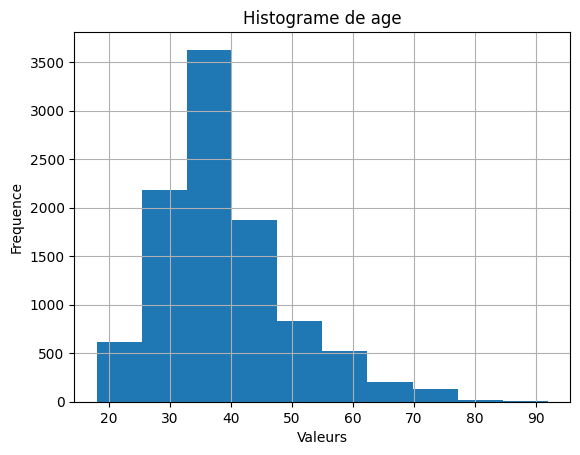

In [37]:
import matplotlib.pyplot as plt
import pandas as pd 

df_pandas=df.toPandas()
df_pandas["Age"].hist()
plt.title("Histograme de age")
plt.xlabel('Valeurs')
plt.ylabel('Frequence')
plt.show()

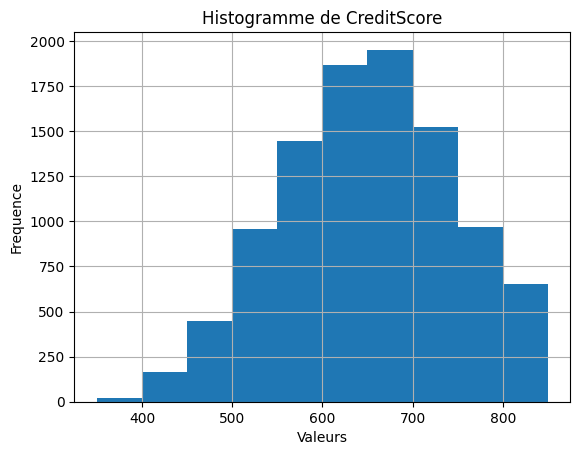

In [38]:
df_pandas['CreditScore'].hist()
plt.title("Histogramme de CreditScore")
plt.xlabel('Valeurs')
plt.ylabel('Frequence')
plt.show()

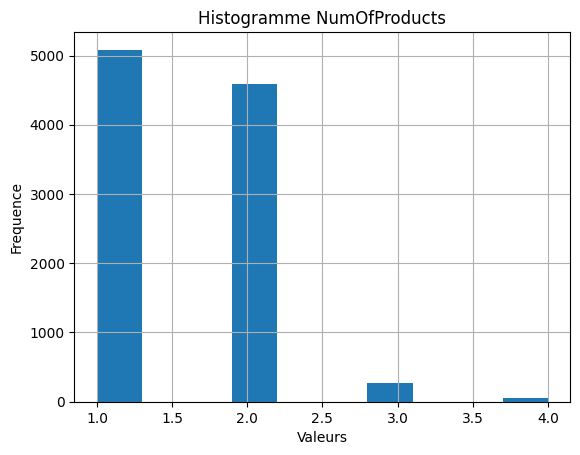

In [39]:
df_pandas['NumOfProducts'].hist()
plt.title('Histogramme NumOfProducts')
plt.xlabel("Valeurs")
plt.ylabel("Frequence")
plt.show()

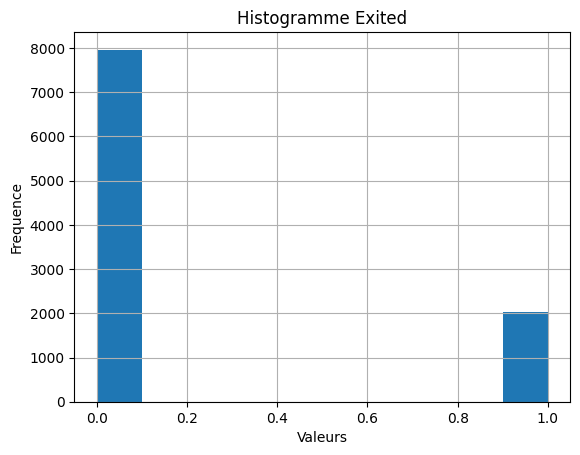

In [41]:
df_pandas['Exited'].hist()
plt.title('Histogramme Exited')
plt.xlabel("Valeurs")
plt.ylabel("Frequence")
plt.show()

BoxPlot

<function matplotlib.pyplot.show(close=None, block=None)>

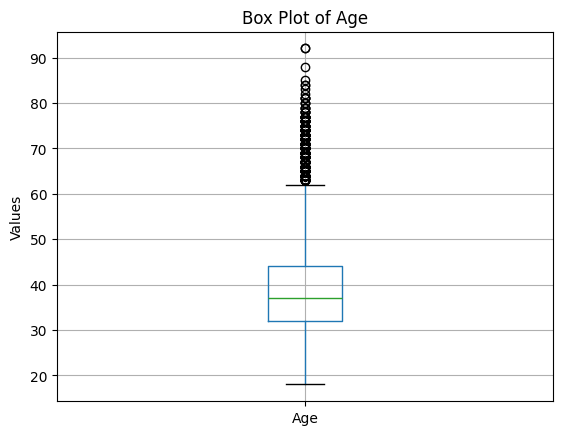

In [55]:
df_pandas.boxplot(column='Age')
plt.title('Box Plot of Age')
plt.ylabel("Values")
plt.show

In [5]:
from pyspark.sql import functions as F

df.groupby('Exited').agg(F.avg("Age").alias("Moyenne_Age")).show()

+------+-----------------+
|Exited|      Moyenne_Age|
+------+-----------------+
|     1| 44.8379970544919|
|     0|37.40838879819164|
+------+-----------------+



In [45]:
df.groupby(['IsActiveMember','Age']).agg(F.count('Age').alias("Nbr_age")).show()

+--------------+---+-------+
|IsActiveMember|Age|Nbr_age|
+--------------+---+-------+
|             0| 25|     70|
|             0| 57|     25|
|             1| 37|    244|
|             0| 65|      6|
|             1| 59|     38|
|             1| 46|    102|
|             1| 25|     84|
|             0| 73|      1|
|             0| 20|     21|
|             0| 48|     87|
|             1| 20|     19|
|             1| 32|    240|
|             1| 49|     62|
|             1| 81|      4|
|             0| 40|    229|
|             1| 76|     10|
|             0| 84|      1|
|             0| 32|    178|
|             1| 63|     27|
|             1| 73|     12|
+--------------+---+-------+
only showing top 20 rows



In [50]:
df.groupby('Age').count().show()

+---+-----+
|Age|count|
+---+-----+
| 31|  404|
| 85|    1|
| 65|   18|
| 53|   74|
| 78|    5|
| 34|  447|
| 81|    4|
| 28|  273|
| 76|   11|
| 27|  209|
| 26|  200|
| 44|  257|
| 22|   84|
| 47|  175|
| 52|  102|
| 40|  432|
| 20|   40|
| 57|   75|
| 54|   84|
| 48|  168|
+---+-----+
only showing top 20 rows



In [14]:
from pyspark.sql import functions as F

df.groupBy("Geography").agg(
    F.count("*").alias("NumCustomers"),
    F.avg("Balance").alias("AvgBalance"),
    F.avg("CreditScore").alias("AvgCreditScore"),
    F.sum("NumOfProducts").alias("total_prodts"),
    (F.avg(F.col("Exited"))*100).alias("NumExited")
).show()

+---------+------------+------------------+-----------------+------------+------------------+
|Geography|NumCustomers|        AvgBalance|   AvgCreditScore|total_prodts|         NumExited|
+---------+------------+------------------+-----------------+------------+------------------+
|  Germany|        2509|119730.11613391782|651.4535671582304|        3813| 32.44320446392985|
|   France|        5014|  62092.6365157559|649.6683286796969|        7676| 16.15476665337056|
|    Spain|        2477| 61818.14776342349|651.3338716188938|        3813|16.673395236172787|
+---------+------------+------------------+-----------------+------------+------------------+



In [56]:
spark.stop()